In [75]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from xgboost import XGBRegressor

### Data Loading

In [76]:
df=pd.read_excel("../resources/premiums_with_life_style_youngs.xlsx")
print(f"Rows {df.shape[0]} - Cols {df.shape[1]}")
df.head(3)

Rows 2941 - Cols 15


,Age,Gender,Region,Marital_status,Physical_Activity,Stress_Level,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459
1,22,Male,Southeast,Unmarried,Medium,High,2,Normal,Regular,Self-Employed,10L - 25L,13,High blood pressure & Heart disease,Bronze,15984
2,22,Female,Southeast,Unmarried,Medium,High,1,Obesity,No Smoking,Freelancer,25L - 40L,30,Diabetes,Bronze,14472


In [77]:
df.columns = df.columns.str.replace(" ",'_').str.lower()
df.head()

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459
1,22,Male,Southeast,Unmarried,Medium,High,2,Normal,Regular,Self-Employed,10L - 25L,13,High blood pressure & Heart disease,Bronze,15984
2,22,Female,Southeast,Unmarried,Medium,High,1,Obesity,No Smoking,Freelancer,25L - 40L,30,Diabetes,Bronze,14472
3,20,Female,Southeast,Married,Low,High,3,Normal,No Smoking,Freelancer,10L - 25L,21,No Disease,Silver,12741
4,20,Female,Southwest,Unmarried,Low,Medium,1,Overweight,Regular,Freelancer,> 40L,85,No Disease,Silver,16302


In [78]:
numerical_column=["age","number_of_dependants","income_lakhs","annual_premium_amount"]
categorial_column=list(set(df.columns)-set(numerical_column))

### Check Null Values

In [79]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
physical_activity        0
stress_level             0
number_of_dependants     0
bmi_category             0
smoking_status           3
employment_status        1
income_level             3
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

### Check Unique Values Of Missing Columns

In [80]:
df['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional', nan], dtype=object)

In [81]:
df['employment_status'].unique()

array(['Freelancer', 'Self-Employed', 'Salaried', nan], dtype=object)

In [82]:
df['income_level'].unique()

array(['<10L', '10L - 25L', '25L - 40L', '> 40L', nan], dtype=object)

### Visualize Income Level Against Income Lakhs

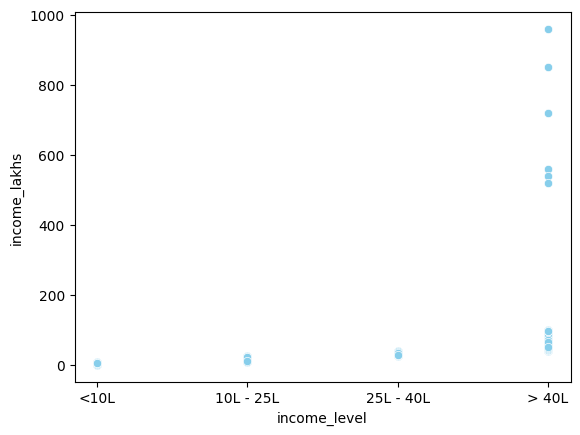

In [83]:
sns.scatterplot(x="income_level", y="income_lakhs", data=df.dropna(), color='skyblue')
plt.show()

### Drop Null Values

In [84]:
df.dropna(inplace=True)

In [85]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
physical_activity        0
stress_level             0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

### Check duplicate Values

In [86]:
df.duplicated().sum()

np.int64(0)

### Check Outliers

In [87]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,2935.000000,2935.000000,2935.000000,2935.000000
mean,21.500170,2.356729,24.134583,9667.215673
std,2.289074,24.382822,38.517101,3322.811609
min,18.000000,0.000000,1.000000,3582.000000
25%,19.000000,0.000000,6.000000,7163.000000
50%,21.000000,0.000000,16.000000,9170.000000
75%,24.000000,1.000000,31.000000,11739.500000
max,25.000000,456.000000,960.000000,24740.000000


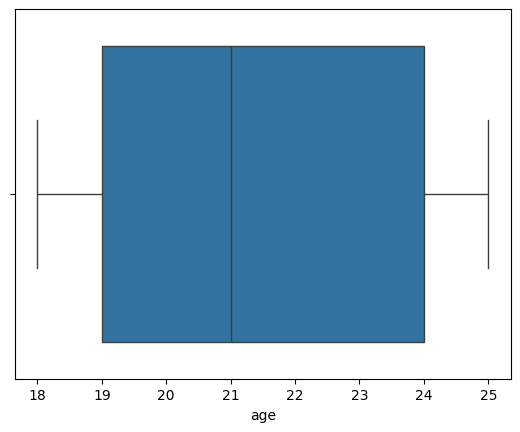

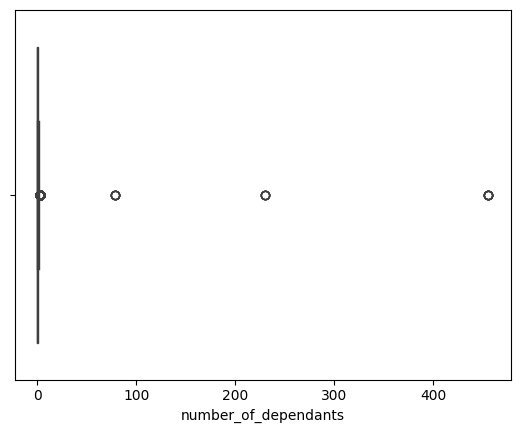

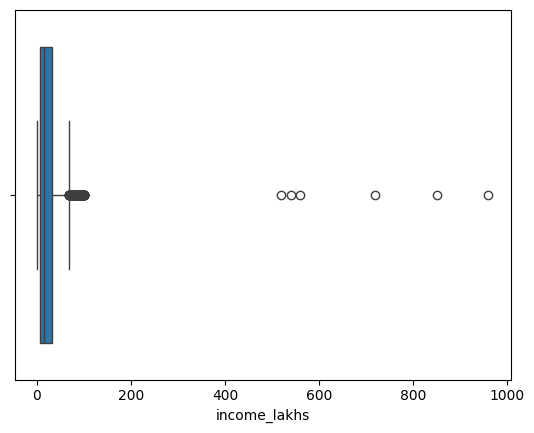

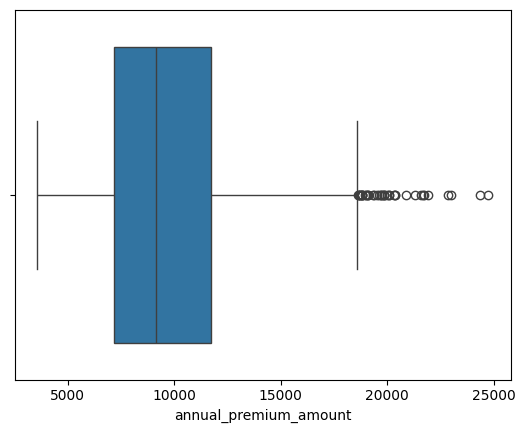

In [88]:
for column in numerical_column:
    sns.boxplot(x=df[column])
    plt.show()

#### Age Outliers

In [89]:
df[df.age>100]['age'].unique()

array([], dtype=int64)

In [90]:
df_copy=df[df.age<=100].copy()

#### Number of dependans outliers

In [91]:
df_copy['number_of_dependants'].unique()

array([  0,   2,   1,   3, 456,  78, 230])

In [92]:
df_copy=df_copy[df_copy['number_of_dependants']<=5].copy()

#### Income lakhs outliers

In [93]:
def get_iqr_bounds(col):
    Q1, Q3=col.quantile([0.25, 0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound,upper_bound

In [94]:
lower_bound_il,upper_bound_il=get_iqr_bounds(df_copy['income_lakhs'])

In [95]:
lower_bound_il,upper_bound_il

(-31.5, 68.5)

In [96]:
quantile_treshold=df_copy.income_lakhs.quantile(0.999)

In [97]:
quantile_treshold

np.float64(573.440000000046)

In [98]:
df_copy=df_copy[df_copy.income_lakhs <= quantile_treshold].copy()

In [99]:
df_copy.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,2914.000000,2914.000000,2914.000000,2914.000000
mean,21.498627,0.722718,23.266301,9664.873027
std,2.287933,0.935613,28.056263,3323.764626
min,18.000000,0.000000,1.000000,3582.000000
25%,19.000000,0.000000,6.000000,7163.000000
50%,21.000000,0.000000,16.000000,9168.000000
75%,24.000000,1.000000,31.000000,11738.750000
max,25.000000,3.000000,560.000000,24740.000000


### Exploratory Data Analysis

#### Univariate Analysis

##### Numerical Variable Analysis

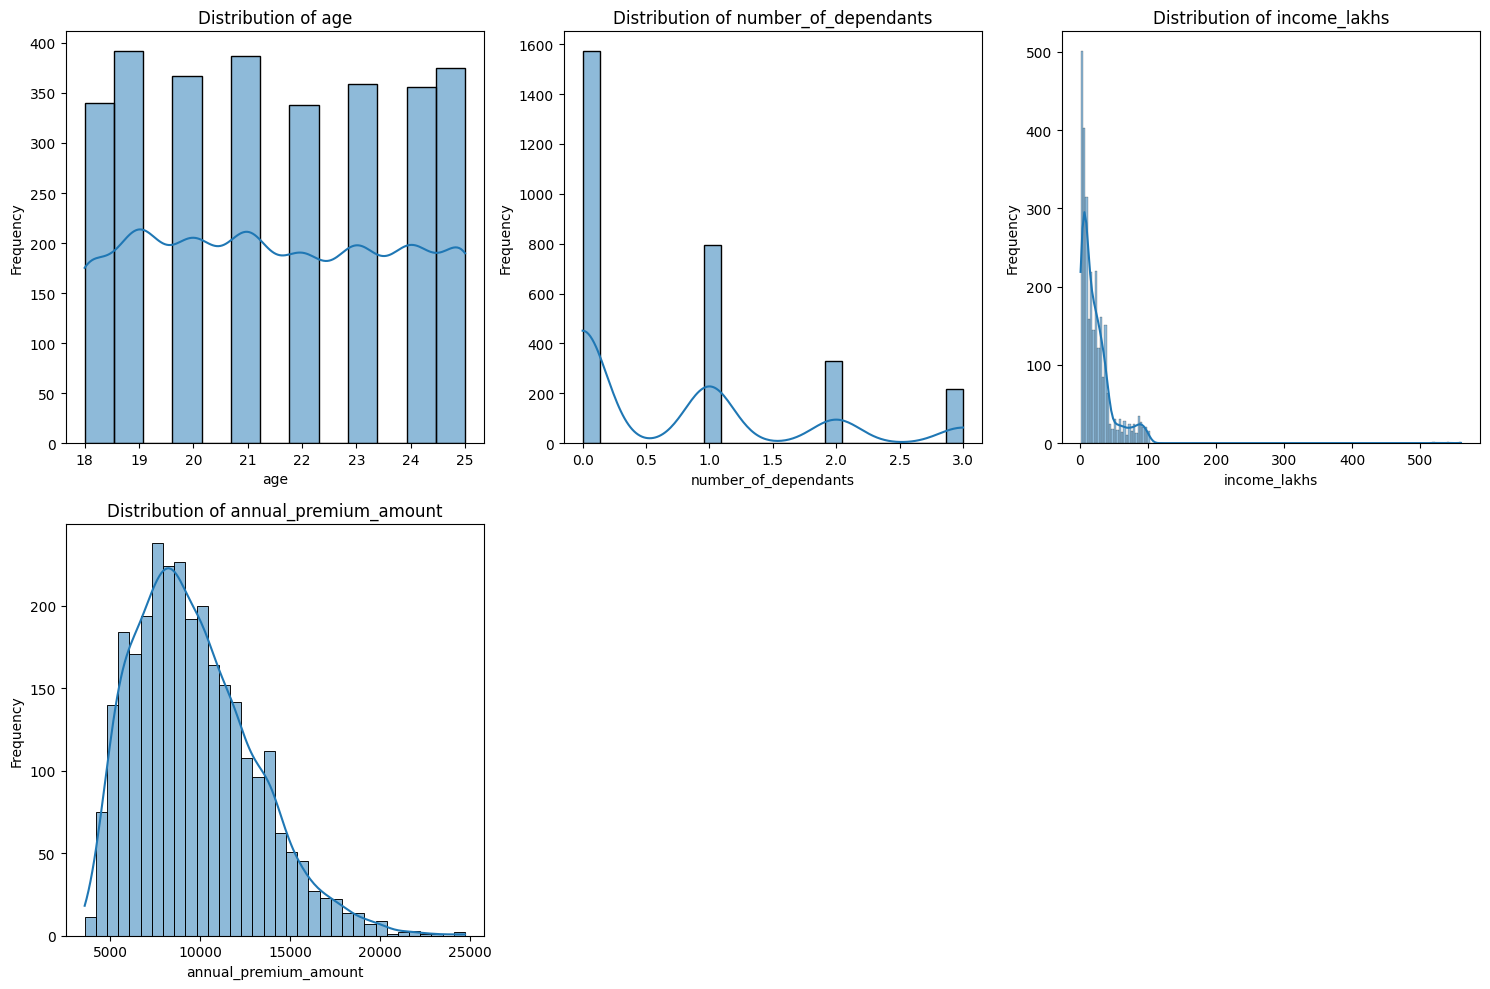

In [100]:
numerical_columns = df_copy.select_dtypes(include=np.number).columns  # Get only numerical columns
num_cols = len(numerical_columns)

# Determine the number of rows and columns for the subplot grid
# You can adjust these based on the number of columns and your desired layout
num_rows = (num_cols + 2) // 3  # Example: roughly 3 columns per row
num_cols_per_row = min(num_cols, 3) # Ensure we don't have more columns than needed

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols_per_row, figsize=(15, 5 * num_rows))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, column in enumerate(numerical_columns):
    sns.histplot(df_copy[column], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}') # Add a title to each subplot
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots if the number of columns isn't a perfect multiple
if num_cols < num_rows * num_cols_per_row:
    for j in range(num_cols, num_rows * num_cols_per_row):
        fig.delaxes(axes[j])

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

##### Categorical Variable Analysis

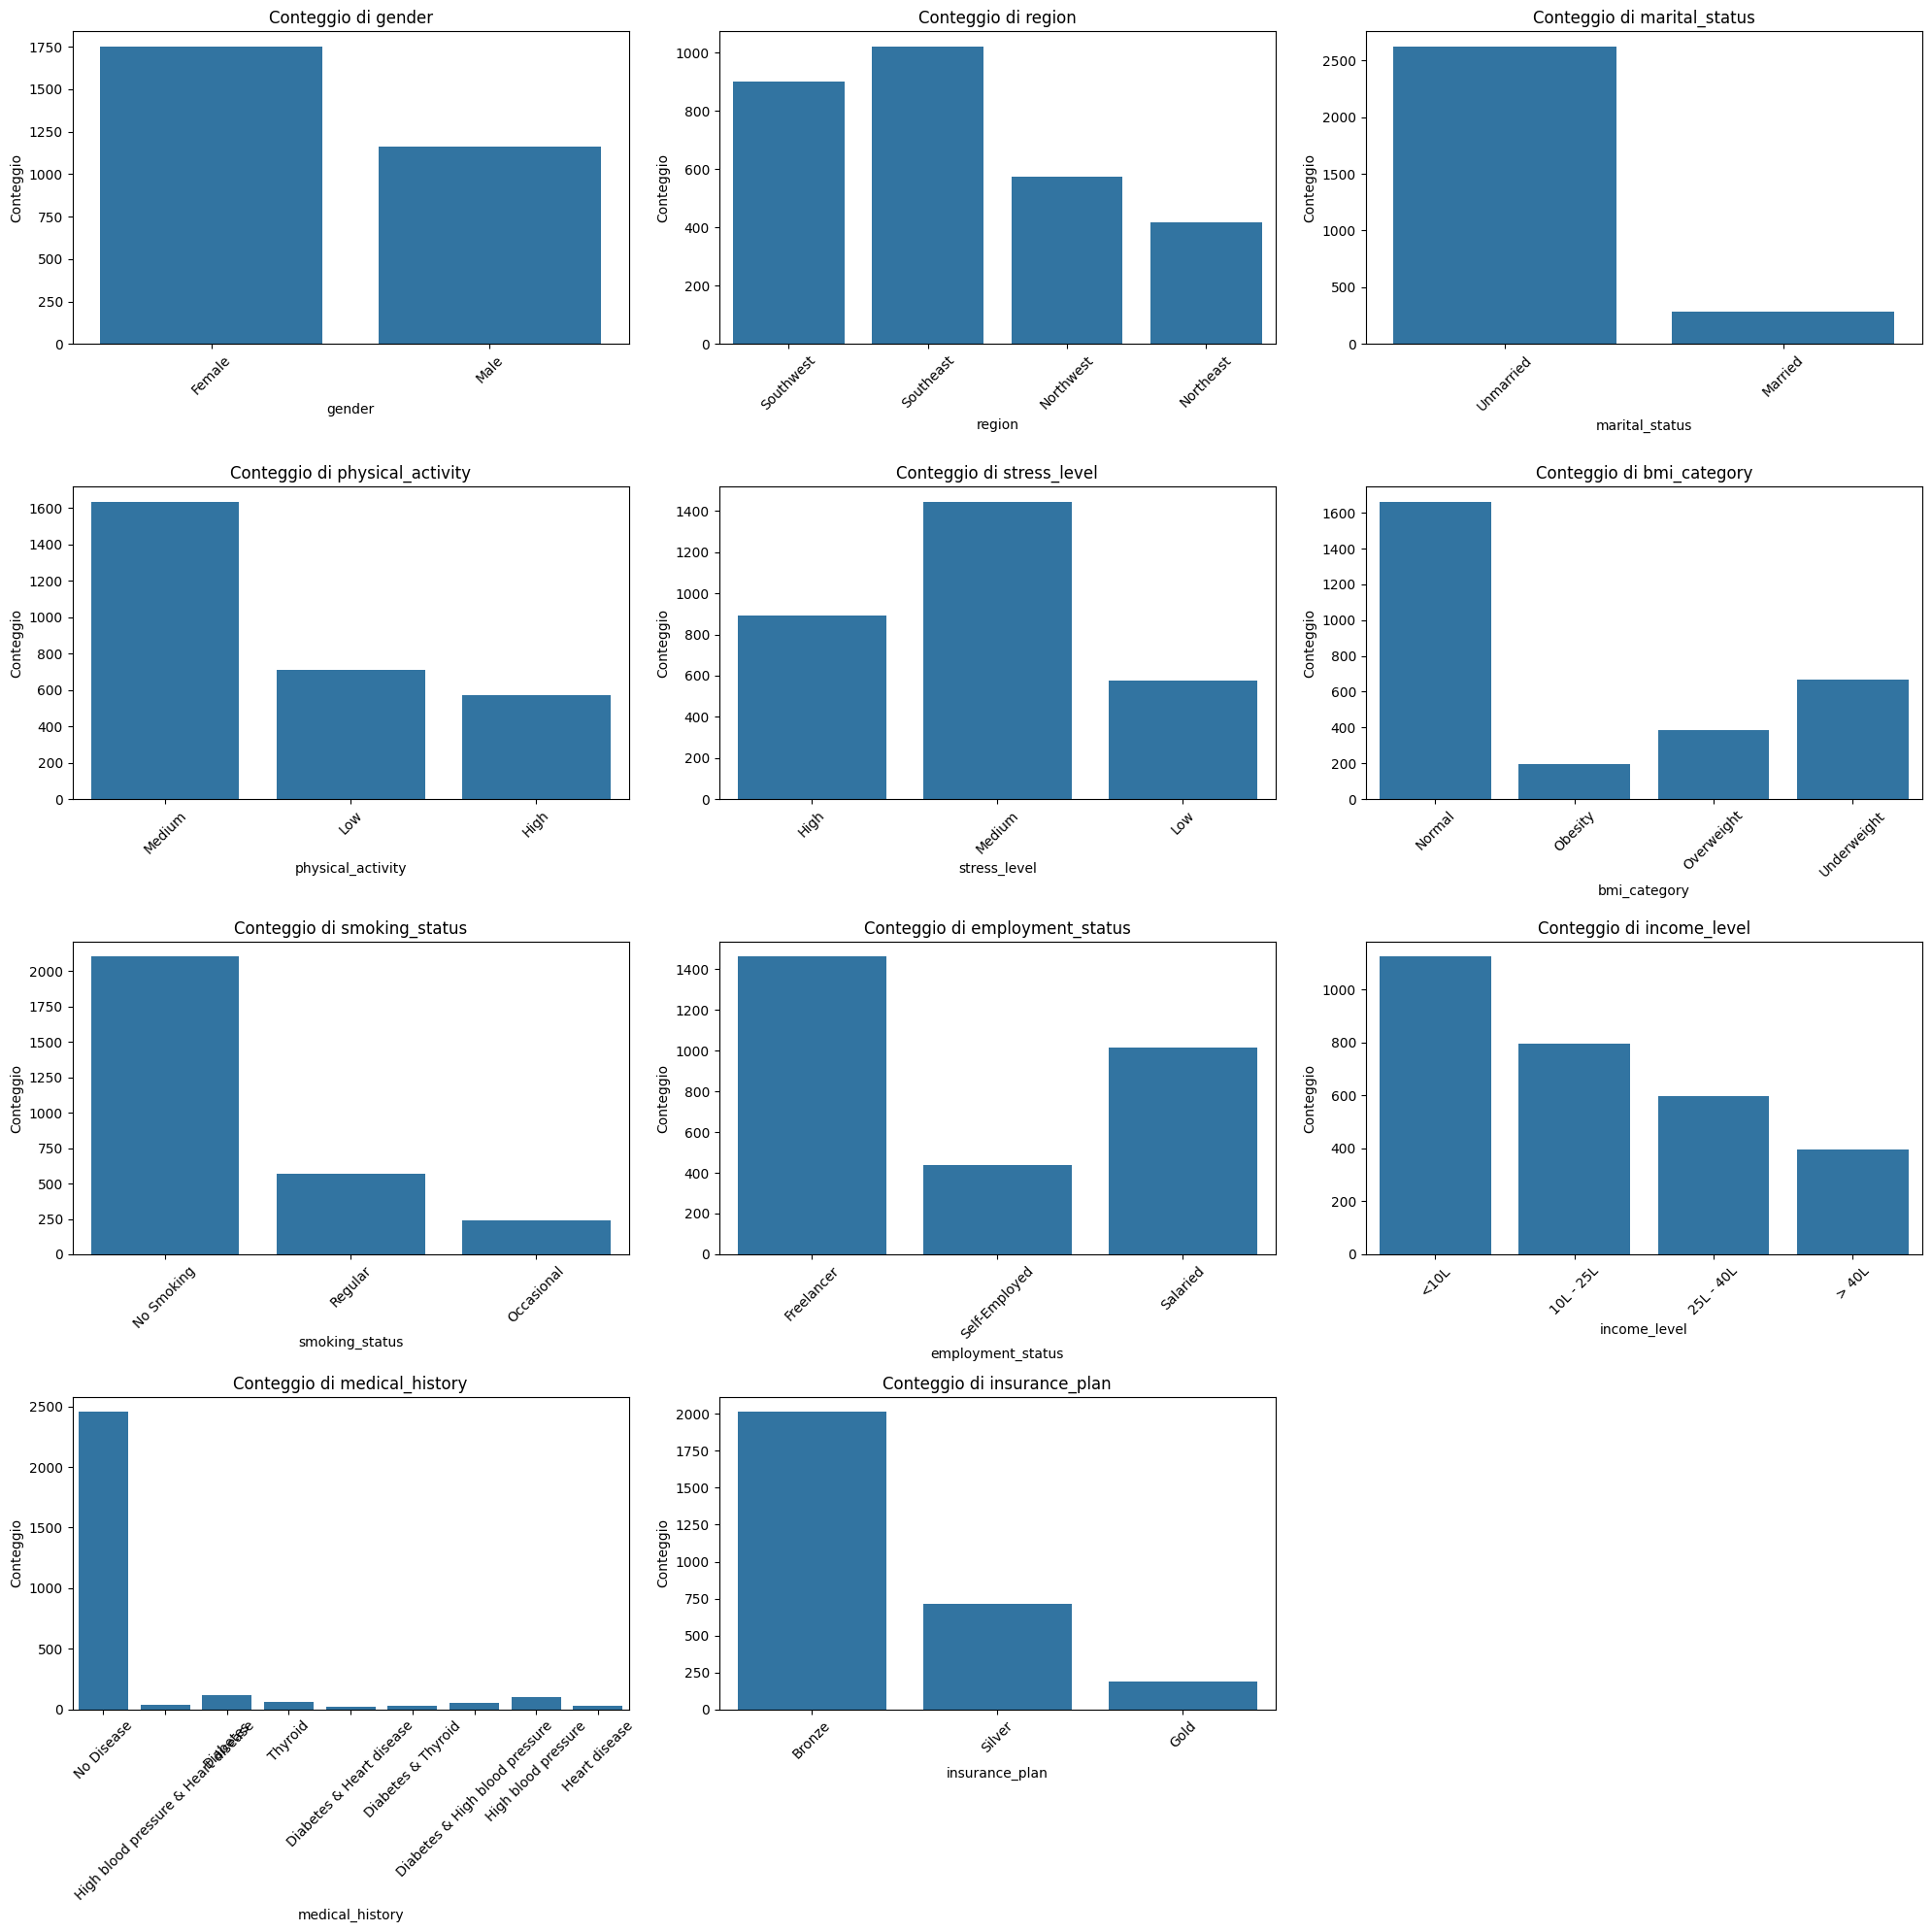

In [101]:
# Assicurati che 'categorical_columns' contenga i nomi delle tue colonne categoriche
categorical_columns = df_copy.select_dtypes(include='object').columns # Verifica che selezioni le colonne corrette
num_cols = len(categorical_columns)

# Calcola il numero di righe e colonne per la griglia di subplot
num_rows = (num_cols + 2) // 3
num_cols_per_row = min(num_cols, 3)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols_per_row, figsize=(20, 5 * num_rows))
axes = axes.flatten()

for i, column in enumerate(categorical_columns):
    sns.countplot(x=df_copy[column], ax=axes[i])
    axes[i].set_title(f'Conteggio di {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Conteggio')
    axes[i].tick_params(axis='x', rotation=45)

# Rimuovi i subplot non utilizzati
if num_cols < num_rows * num_cols_per_row:
    for j in range(num_cols, num_rows * num_cols_per_row):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Bivariant Analysis

##### Numerical Features vs annual premium

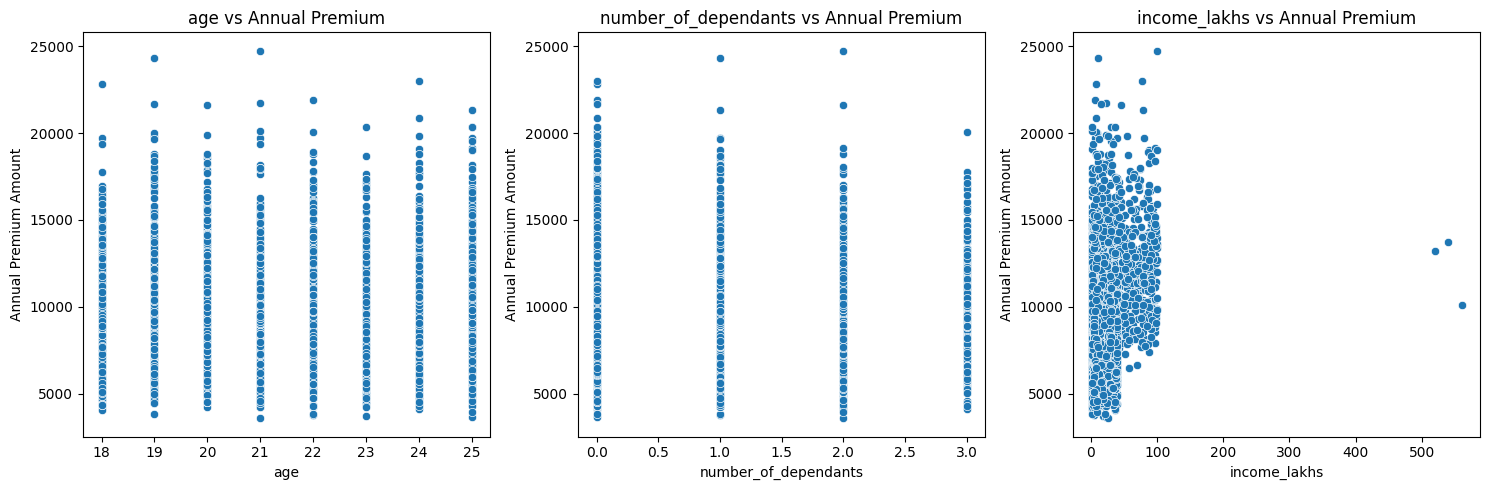

In [102]:
# Assicurati che 'numerical_column' contenga i nomi delle tue colonne numeriche
numerical_columns = df_copy.select_dtypes(include=np.number).columns.tolist()
numerical_columns_to_plot = [col for col in numerical_columns if col != "annual_premium_amount"]
num_cols = len(numerical_columns_to_plot)

# Calcola il numero di righe e colonne per la griglia di subplot
num_rows = (num_cols + 2) // 3
num_cols_per_row = min(num_cols, 3)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols_per_row, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_columns_to_plot):
    sns.scatterplot(data=df_copy, x=col, y="annual_premium_amount", ax=axes[i])
    axes[i].set_title(f'{col} vs Annual Premium')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Annual Premium Amount')

# Rimuovi i subplot non utilizzati
if num_cols < num_rows * num_cols_per_row:
    for j in range(num_cols, num_rows * num_cols_per_row):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

##### Employment Status With Numerical Features

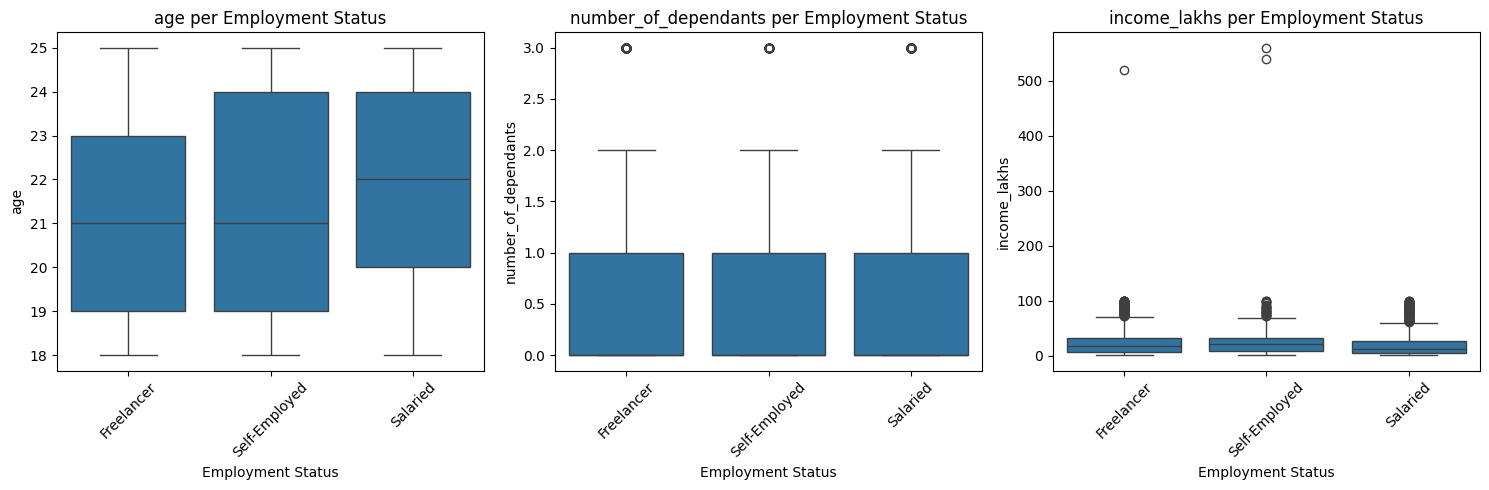

In [103]:
numerical_columns = df_copy.select_dtypes(include=np.number).columns.tolist()
numerical_columns_to_plot = [col for col in numerical_columns if col != "annual_premium_amount"]
num_cols = len(numerical_columns_to_plot)
num_rows = (num_cols + 2) // 3
num_cols_per_row = min(num_cols, 3)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols_per_row, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_columns_to_plot):
    sns.boxplot(data=df_copy, x="employment_status", y=col, ax=axes[i])
    axes[i].set_title(f'{col} per Employment Status')
    axes[i].set_xlabel('Employment Status')
    axes[i].set_ylabel(col)
    axes[i].tick_params(axis='x', rotation=45)

if num_cols < num_rows * num_cols_per_row:
    for j in range(num_cols, num_rows * num_cols_per_row):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

##### Stress Factor With Medical History

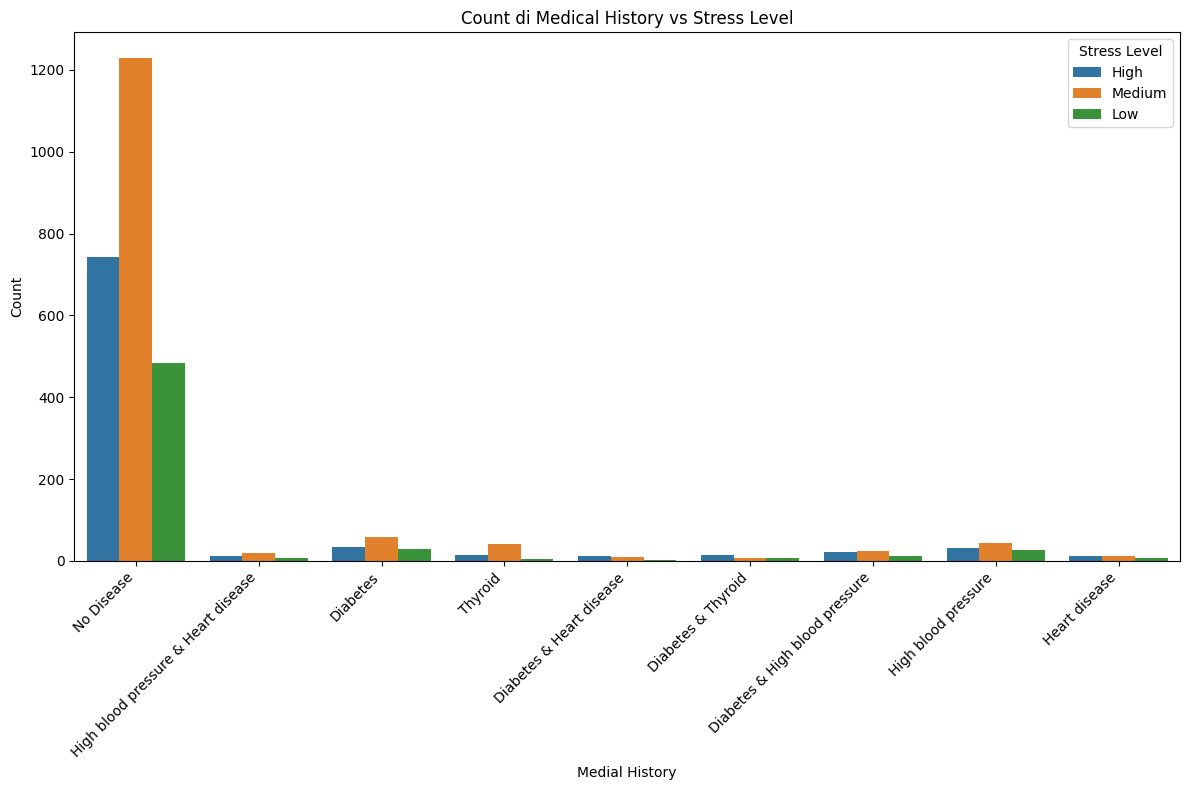

In [104]:
# Imposta le dimensioni della figura prima di creare il plot
plt.figure(figsize=(12, 8))  # Puoi modificare i valori (larghezza, altezza) a tuo piacimento

sns.countplot(x='medical_history', hue='stress_level', data=df_copy)

# Aggiungi un titolo e delle etichette per chiarezza
plt.title('Count di Medical History vs Stress Level')
plt.xlabel('Medial History')
plt.ylabel('Count')

# Ruota le etichette sull'asse x se necessario per evitare sovrapposizioni
plt.xticks(rotation=45, ha='right')

# Mostra la legenda (dovrebbe essere automatica con 'hue')
plt.legend(title='Stress Level')

plt.tight_layout()  # Ottimizza il layout per evitare che gli elementi si sovrappongano
plt.show()

#### Multivariant Analysis

In [105]:
for col in categorial_column:
    print(col,":",df_copy[col].unique())

income_level : ['<10L' '10L - 25L' '25L - 40L' '> 40L']
stress_level : ['High' 'Medium' 'Low']
employment_status : ['Freelancer' 'Self-Employed' 'Salaried']
smoking_status : ['No Smoking' 'Regular' 'Occasional']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
region : ['Southwest' 'Southeast' 'Northwest' 'Northeast']
physical_activity : ['Medium' 'Low' 'High']
gender : ['Female' 'Male']
marital_status : ['Unmarried' 'Married']
medical_history : ['No Disease' 'High blood pressure & Heart disease' 'Diabetes' 'Thyroid'
 'Diabetes & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & High blood pressure' 'High blood pressure' 'Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


##### Insurance Level Vs Insurance plan

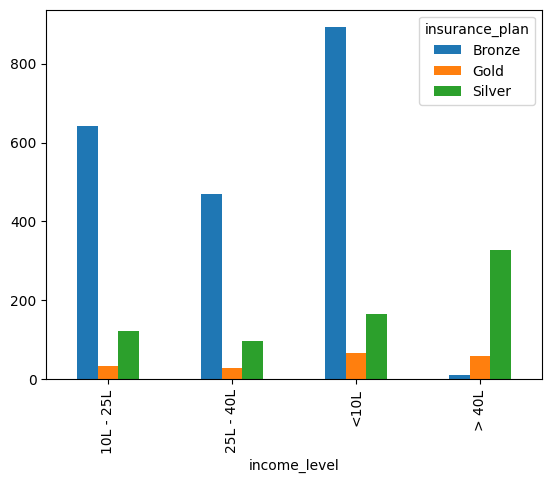

In [106]:
crosstab=pd.crosstab(df_copy["income_level"],df_copy["insurance_plan"])
crosstab.plot(kind="bar")
plt.show()

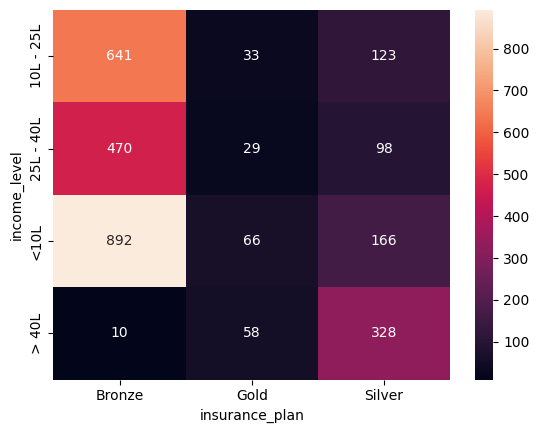

In [107]:
sns.heatmap(crosstab,annot=True,fmt="d")
plt.show()

##### Encoding Categorical Variables

In [108]:
risk_scores={
    "Diabetes":6,
    "Heart disease":8,
    "High blood pressure":6,
    "Thyroid":5,
    "No Disease":0,
    "None":0
}
df_copy[["disease1","disease2"]]=df_copy["medical_history"].str.split(" & ",expand=True).apply(lambda x: x.str.lower())

##### Calculate Life Style Risk

Calculate physical_activity

In [109]:
physical_activity_risk={
    "High": 0,
    "Medium": 1,
    "Low":4
}
df_copy['physical_activity_risk_score'] = 0

df_copy['physical_activity_risk_score'] += df_copy["physical_activity"].map(physical_activity_risk)

In [110]:
stress_level_risk={
    "High": 4,
    "Medium": 1,
    "Low":0
}
df_copy['stress_level_risk_score'] = 0

df_copy['stress_level_risk_score'] += df_copy["stress_level"].map(physical_activity_risk)

In [111]:
df_copy['life_style_risk_score'] = 0
df_copy['life_style_risk_score']+=df_copy['stress_level_risk_score']+df_copy['physical_activity_risk_score']
max_score = df_copy['life_style_risk_score'].max()
min_score = df_copy['life_style_risk_score'].min()

df_copy['normalized_ls_risk_score'] = (df_copy['life_style_risk_score'] - min_score) / (max_score - min_score)

In [112]:
df_copy.head(5)

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,...,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,physical_activity_risk_score,stress_level_risk_score,life_style_risk_score,normalized_ls_risk_score
0,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,...,9,No Disease,Bronze,8459,no disease,None,1,0,1,0.125
1,22,Male,Southeast,Unmarried,Medium,High,2,Normal,Regular,Self-Employed,...,13,High blood pressure & Heart disease,Bronze,15984,high blood pressure,heart disease,1,0,1,0.125
2,22,Female,Southeast,Unmarried,Medium,High,1,Obesity,No Smoking,Freelancer,...,30,Diabetes,Bronze,14472,diabetes,None,1,0,1,0.125
3,20,Female,Southeast,Married,Low,High,3,Normal,No Smoking,Freelancer,...,21,No Disease,Silver,12741,no disease,None,4,0,4,0.500
4,20,Female,Southwest,Unmarried,Low,Medium,1,Overweight,Regular,Freelancer,...,85,No Disease,Silver,16302,no disease,None,4,1,5,0.625


In [113]:
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df_copy[["disease1","disease2"]]=df_copy["medical_history"].str.split(" & ",expand=True).apply(lambda x: x.str.lower())
df_copy['disease1'].fillna('none', inplace=True)
df_copy['disease2'].fillna('none', inplace=True)
df_copy['total_risk_score'] = df_copy['life_style_risk_score']

for disease in ['disease1', 'disease2']:
    df_copy['total_risk_score'] += df_copy[disease].map(risk_scores)

# Normalize the risk score to a range of 0 to 1
max_score = df_copy['total_risk_score'].max()
min_score = df_copy['total_risk_score'].min()
df_copy['normalized_risk_score'] = (df_copy['total_risk_score'] - min_score) / (max_score - min_score)
df_copy.head(3)


/tmp/ipykernel_21423/3511688179.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['disease1'].fillna('none', inplace=True)
/tmp/ipykernel_21423/3511688179.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,...,insurance_plan,annual_premium_amount,disease1,disease2,physical_activity_risk_score,stress_level_risk_score,life_style_risk_score,normalized_ls_risk_score,total_risk_score,normalized_risk_score
0,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,...,Bronze,8459,no disease,none,1,0,1,0.125,1,0.045455
1,22,Male,Southeast,Unmarried,Medium,High,2,Normal,Regular,Self-Employed,...,Bronze,15984,high blood pressure,heart disease,1,0,1,0.125,15,0.681818
2,22,Female,Southeast,Unmarried,Medium,High,1,Obesity,No Smoking,Freelancer,...,Bronze,14472,diabetes,none,1,0,1,0.125,7,0.318182


In [114]:

insurance_plan_map = {'Gold': 3, 'Silver': 2, 'Bronze': 1}
income_level_map = {'<10L': 1, '10L - 25L': 2, '25L - 40L': 3, '> 40L': 4}


df_copy["insurance_plan"] = df_copy["insurance_plan"].map(insurance_plan_map)
df_copy["income_level"] = df_copy["income_level"].map(income_level_map)


In [115]:
df_copy["employment_status"].unique()

array(['Freelancer', 'Self-Employed', 'Salaried'], dtype=object)

In [116]:
df_copy["employment_status"]=df_copy["employment_status"].replace({"Self-Employed":"Self_Employed"})

In [117]:
df_copy["employment_status"] = df_copy["employment_status"].str.lower()
df_copy["region"] = df_copy["region"].str.lower()
df_copy["marital_status"] = df_copy["marital_status"].str.lower()
df_copy["bmi_category"] = df_copy["bmi_category"].str.lower()
df_copy["smoking_status"] = df_copy["smoking_status"].str.lower()

In [118]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df_encoded = pd.get_dummies(df_copy, columns=nominal_cols, drop_first=True, dtype=int)
df_encoded.head(3)

,age,physical_activity,stress_level,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,...,region_southeast,region_southwest,marital_status_unmarried,bmi_category_obesity,bmi_category_overweight,bmi_category_underweight,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self_employed
0,18,Medium,High,0,1,9,No Disease,1,8459,no disease,...,0,1,1,0,0,0,0,0,0,0
1,22,Medium,High,2,2,13,High blood pressure & Heart disease,1,15984,high blood pressure,...,1,0,1,0,0,0,0,1,0,1
2,22,Medium,High,1,3,30,Diabetes,1,14472,diabetes,...,1,0,1,1,0,0,0,0,0,0


In [119]:
df_encoded=df_encoded.drop(columns=["medical_history","disease1","disease2","total_risk_score","stress_level_risk_score","physical_activity_risk_score",
                                    "life_style_risk_score","physical_activity","stress_level"])

In [120]:
print(df_encoded)

      age  number_of_dependants  income_level  income_lakhs  insurance_plan  \
0      18                     0             1             9               1   
1      22                     2             2            13               1   
2      22                     1             3            30               1   
3      20                     3             2            21               2   
4      20                     1             4            85               2   
...   ...                   ...           ...           ...             ...   
2936   21                     0             1             9               1   
2937   18                     0             1             5               1   
2938   19                     0             4            97               3   
2939   24                     0             3            29               1   
2940   18                     0             1             6               2   

      annual_premium_amount  normalized_ls_risk_sco

##### Correlation Heatmap

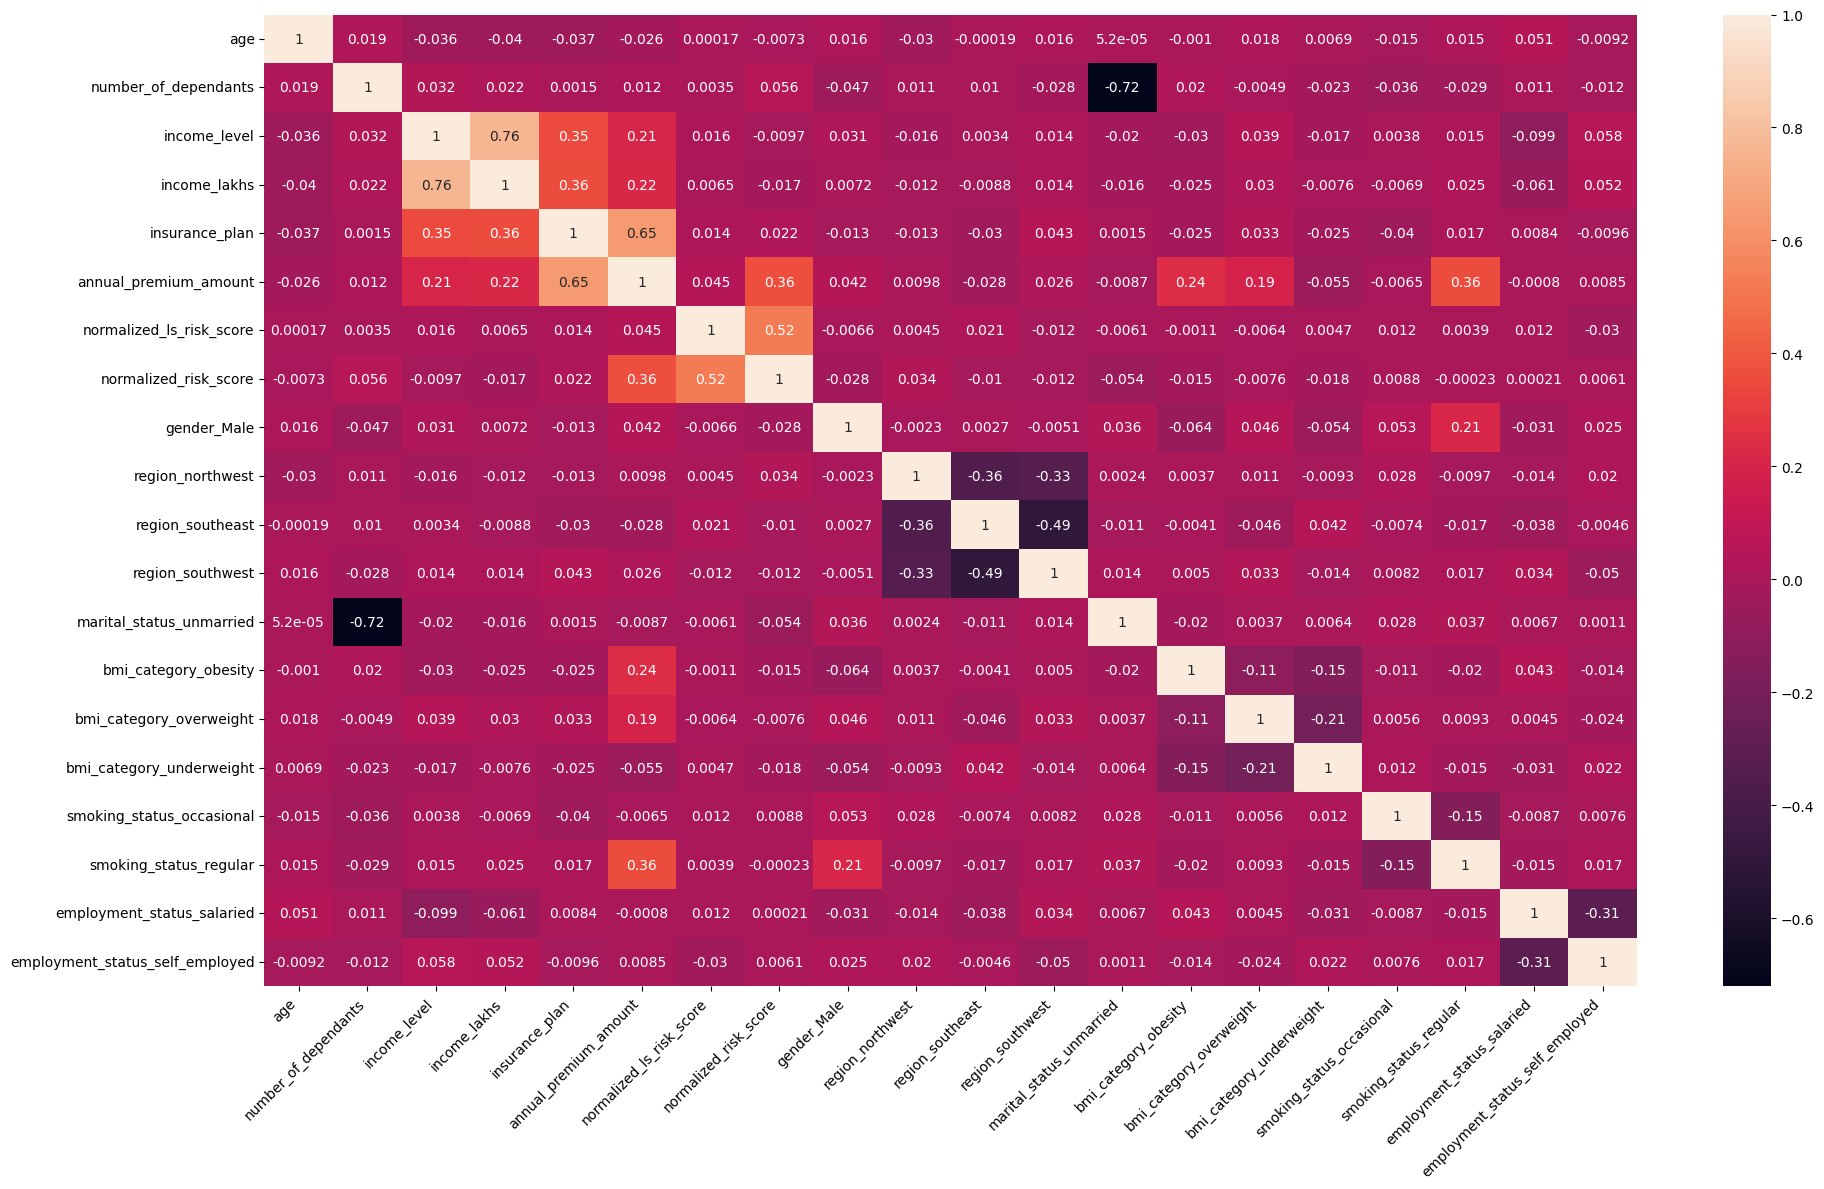

In [121]:
cm = df_encoded.corr()

plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

##### Detecting Multicollinearity with VIF

In [122]:
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [123]:
X = df_encoded.drop('annual_premium_amount', axis='columns')
y = df_encoded['annual_premium_amount']

##### MinMax Scaler

In [124]:
# scale features
cols_to_scale = ['age', 'income_level',  'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()
X[cols_to_scale]=scaler.fit_transform(X[cols_to_scale])

In [125]:
calculate_vif(X)

,Column,VIF
0,age,3.205978
1,number_of_dependants,1.939354
2,income_level,5.020182
3,income_lakhs,3.993769
4,insurance_plan,1.622969
5,normalized_ls_risk_score,4.088446
6,normalized_risk_score,3.020587
7,gender_Male,1.748613
8,region_northwest,2.158893
9,region_southeast,3.051180


In [126]:
calculate_vif(X.drop(columns=['income_level','number_of_dependants','marital_status_unmarried'], axis="columns"))

,Column,VIF
0,age,2.842770
1,income_lakhs,1.825946
2,insurance_plan,1.583005
3,normalized_ls_risk_score,3.928782
4,normalized_risk_score,2.983036
5,gender_Male,1.701246
6,region_northwest,1.720564
7,region_southeast,2.289848
8,region_southwest,2.170500
9,bmi_category_obesity,1.110796


In [127]:
# we will drop income_lakhs due to high VIF value
X_reduced = X.drop(columns=['income_level','number_of_dependants','marital_status_unmarried'], axis="columns")

#### Train Models

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3)

##### Linear Regression

In [129]:
regr = LinearRegression()
regr.fit(X_train, y_train)
print(f"Score {regr.score(X_test, y_test)}")

Score 0.8027005815217892


In [130]:
y_pred=regr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Linear Regression ==> MSE:  2012696.7040842143 RMSE:  1418.695423297127


#### Ridge

In [131]:
model_rg = Ridge(alpha=1)
model_rg.fit(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score = model_rg.score(X_train, y_train)
train_score, test_score

(0.8115760522624331, 0.8028136851211435)

In [132]:
y_pred = model_rg.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Ridge Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Ridge Regression ==> MSE:  2011542.9082778392 RMSE:  1418.2887252875696


#### Xgboost Regressor

In [133]:
model_xgb = XGBRegressor(n_estimators=20, max_depth=3)
model_xgb.fit(X_train, y_train)
model_xgb.score(X_test, y_test)

0.8147344589233398

In [134]:
y_pred = model_xgb.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("XGBoost Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

XGBoost Regression ==> MSE:  1889936.375 RMSE:  1374.7495681032237


In [135]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [30, 70, 100],
    'learning_rate': [0.01, 0.2, 0.5],
    'max_depth': [2, 3, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_
best_model = random_search.best_estimator_

In [136]:
print("Best parameters found: ", random_search.best_params_)
print("Best R-squared score: ", random_search.best_score_)

Best parameters found:  {'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.2}
Best R-squared score:  0.8446501890818278


In [137]:
X_train

,age,income_lakhs,insurance_plan,normalized_ls_risk_score,normalized_risk_score,gender_Male,region_northwest,region_southeast,region_southwest,bmi_category_obesity,bmi_category_overweight,bmi_category_underweight,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self_employed
1342,0.285714,0.025045,0.0,0.250,0.090909,0,0,0,1,0,0,0,0,0,0,0
2539,0.857143,0.037567,0.0,0.500,0.181818,0,0,1,0,0,0,0,0,0,1,0
1398,0.714286,0.003578,0.0,0.125,0.045455,0,0,0,1,0,0,0,0,0,1,0
2313,1.000000,0.042934,0.0,0.250,0.090909,0,0,1,0,0,0,0,0,0,0,0
211,0.285714,0.000000,0.0,0.500,0.181818,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,0.857143,0.012522,0.0,0.250,0.636364,1,1,0,0,0,0,0,1,0,0,1
2866,0.285714,0.064401,0.0,0.625,0.227273,0,0,1,0,0,0,0,0,0,0,0
816,0.571429,0.048301,0.0,0.250,0.090909,1,0,0,1,0,0,0,0,1,1,0
1978,0.428571,0.039356,0.5,0.625,0.863636,0,0,0,1,1,0,0,0,0,0,0


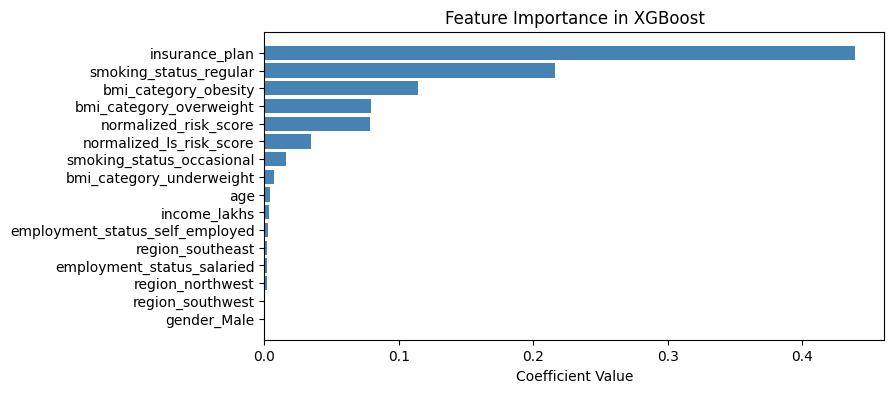

In [138]:
feature_importance = best_model.feature_importances_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

#### Error Analysis

In [139]:
y_pred= best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct= residuals*100/y_test

results_df = pd.DataFrame({
    "actual":y_test,
    "predicted":y_pred,
    "diff":residuals,
    "diff_pct":residuals_pct
})
results_df.head()

,actual,predicted,diff,diff_pct
684,12080,14023.181641,1943.181641,16.085941
385,13844,12854.447266,-989.552734,-7.147882
432,15368,13830.904297,-1537.095703,-10.001924
1787,10701,10548.660156,-152.339844,-1.423604
318,7526,7205.201660,-320.798340,-4.262534


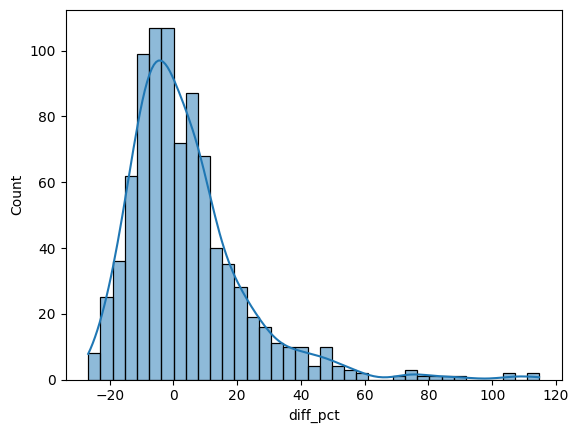

In [140]:
sns.histplot(results_df["diff_pct"],kde=True)
plt.show()

In [141]:
extreme_error_threshold=10
extreme_results_df=results_df[np.abs(results_df.diff_pct)>extreme_error_threshold]
extreme_results_df.shape

(386, 4)

In [142]:
extreme_errors_pct=extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_errors_pct

44.114285714285714

In [143]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head(2)

,age,income_lakhs,insurance_plan,normalized_ls_risk_score,normalized_risk_score,gender_Male,region_northwest,region_southeast,region_southwest,bmi_category_obesity,bmi_category_overweight,bmi_category_underweight,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self_employed
684,0.857143,0.001789,0.5,0.125,0.045455,0,0,1,0,1,0,0,0,0,0,0
432,0.285714,0.059034,0.0,0.625,0.500000,0,1,0,0,0,1,0,0,1,0,1


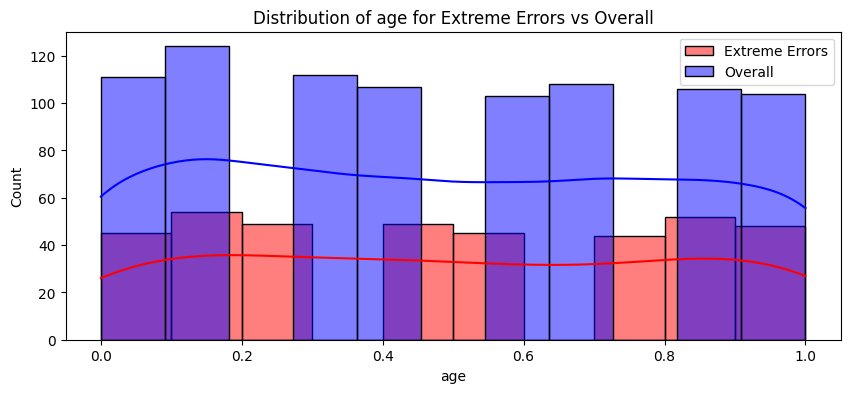

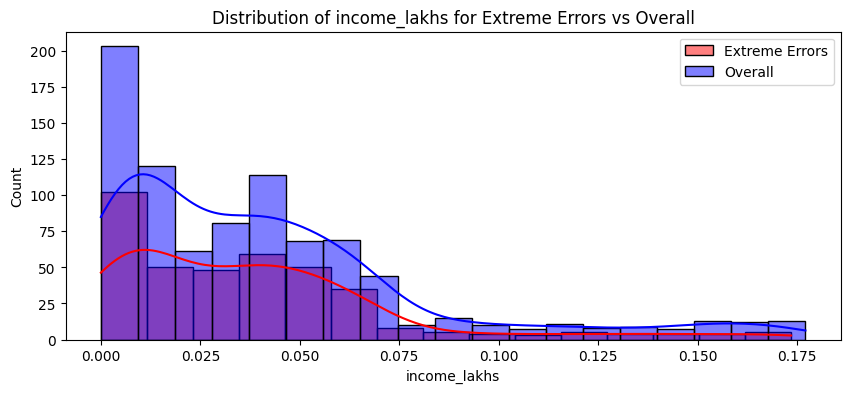

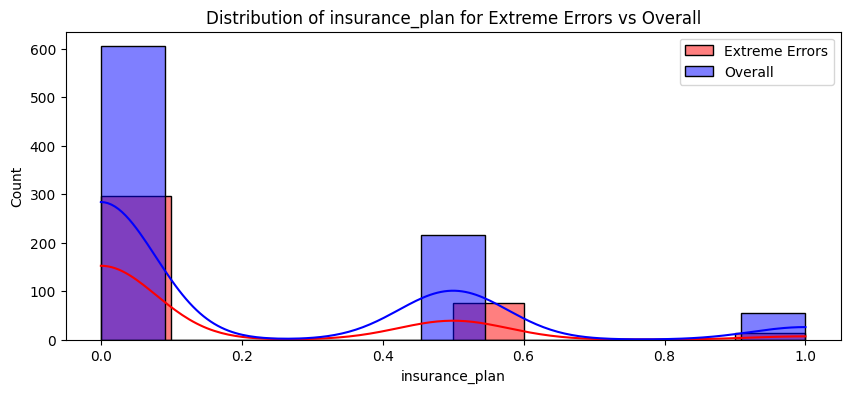

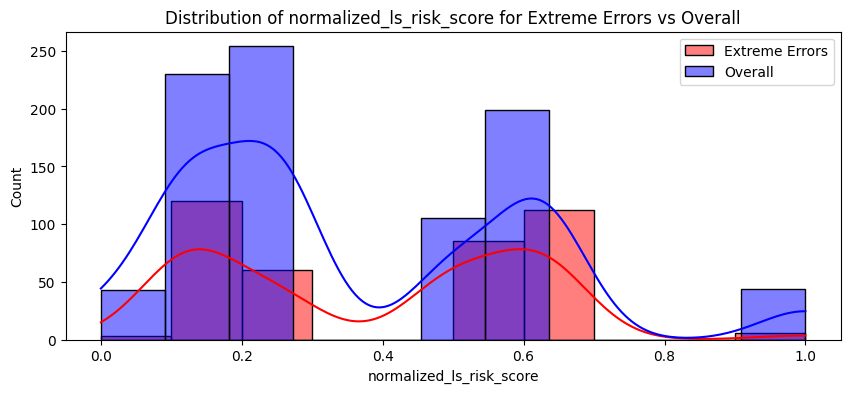

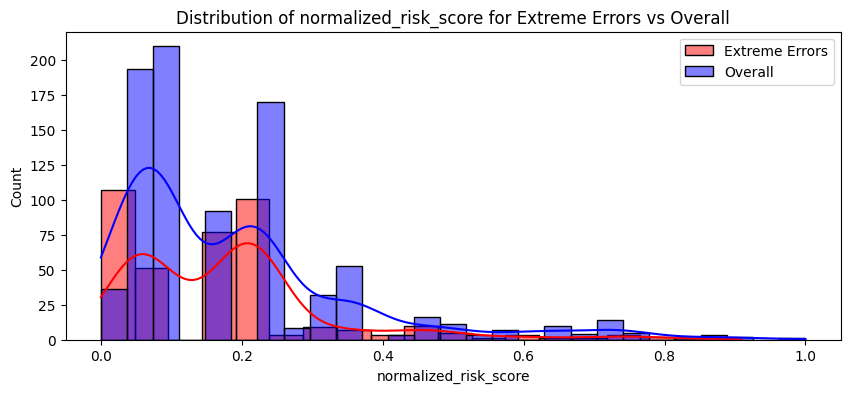

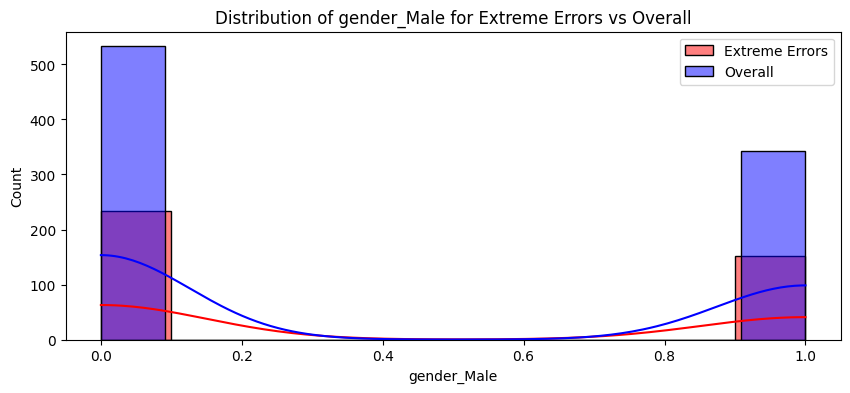

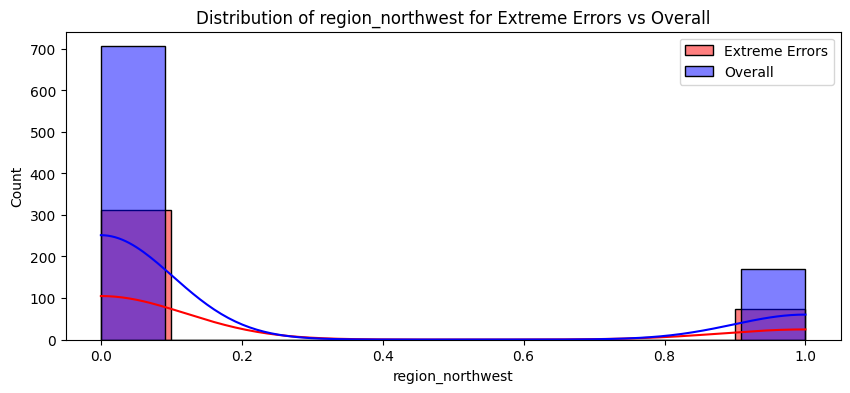

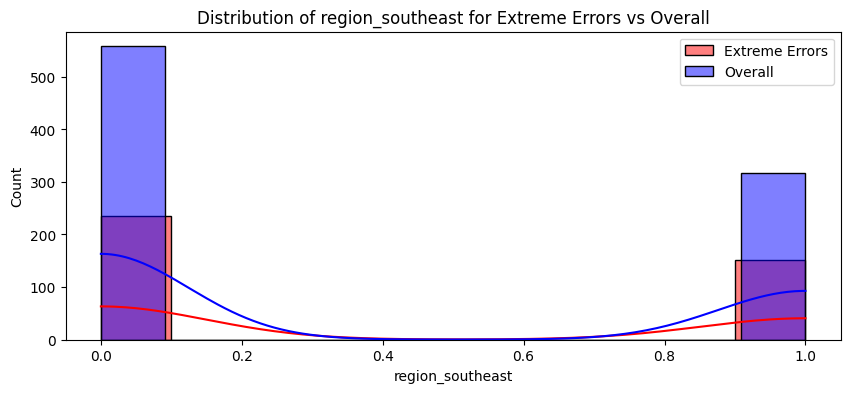

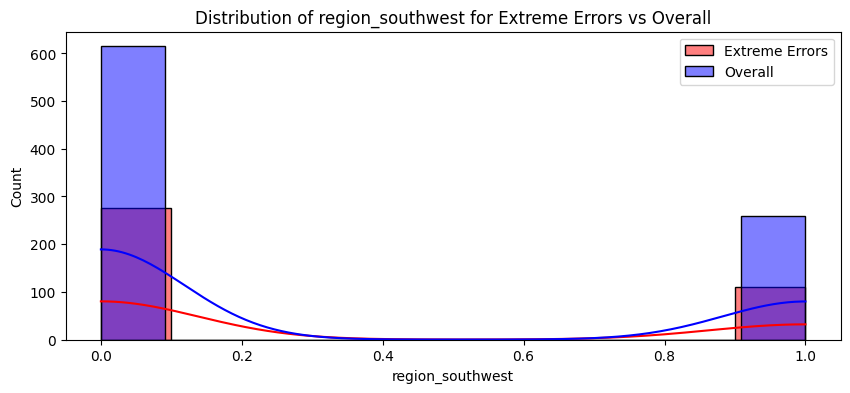

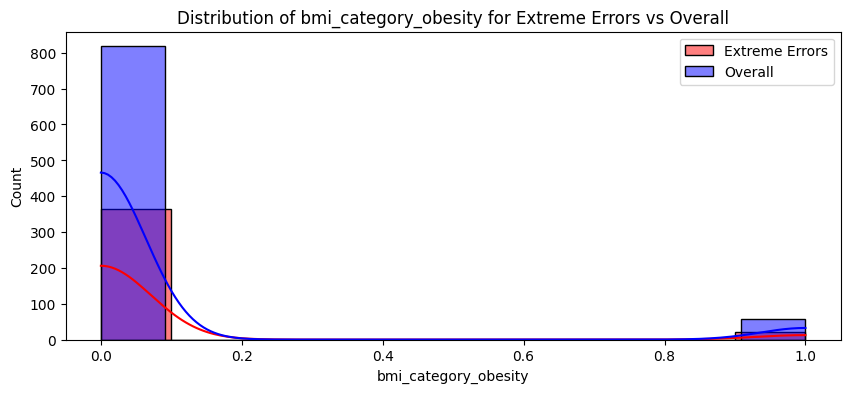

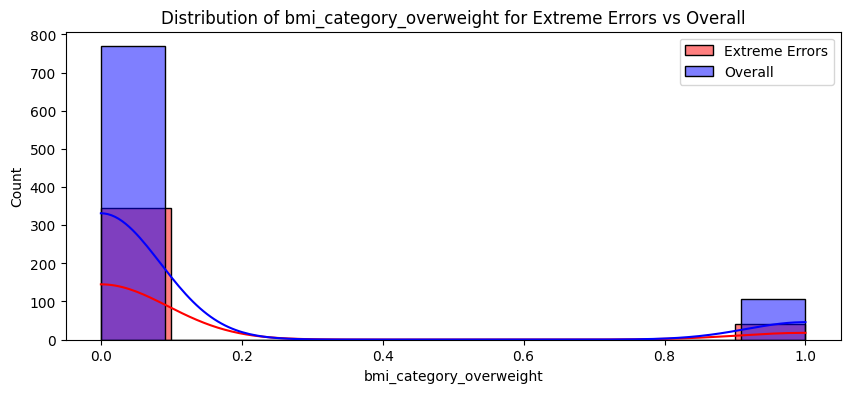

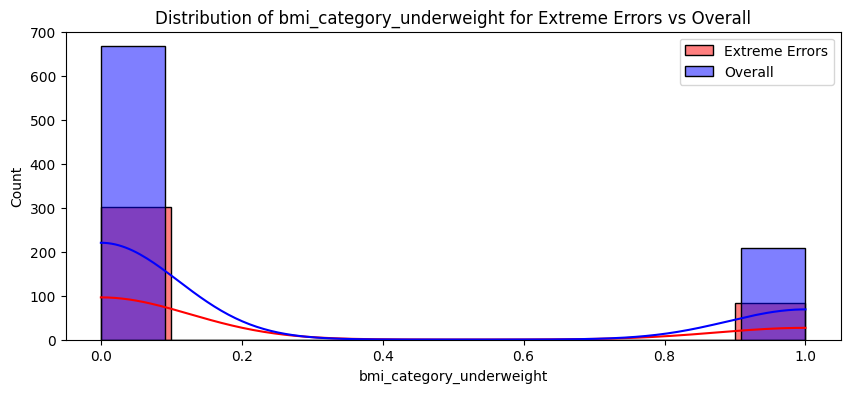

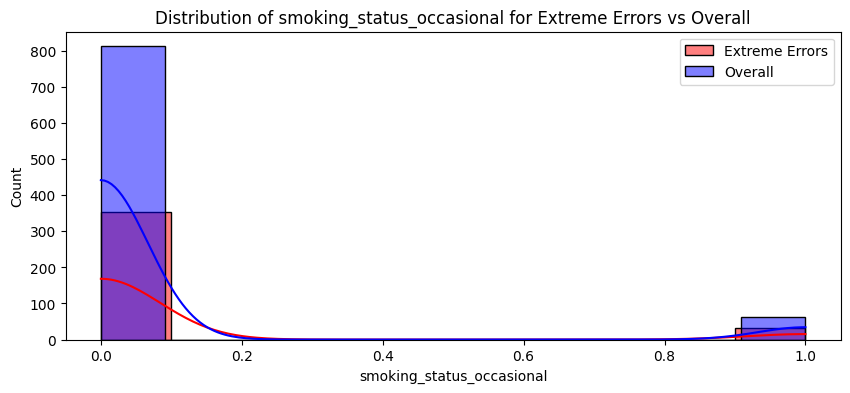

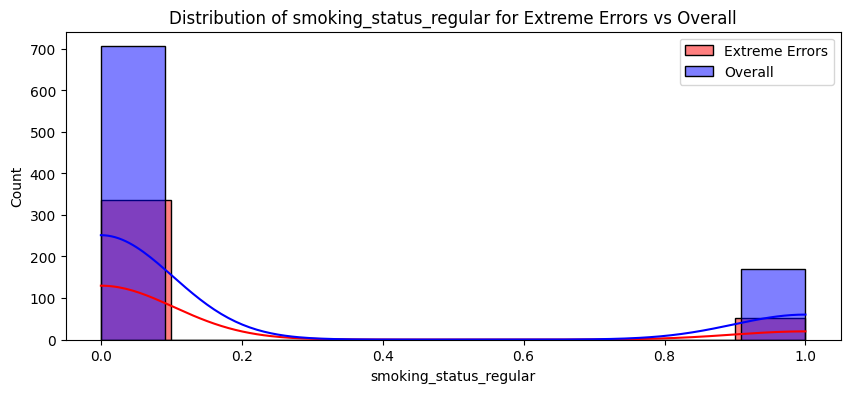

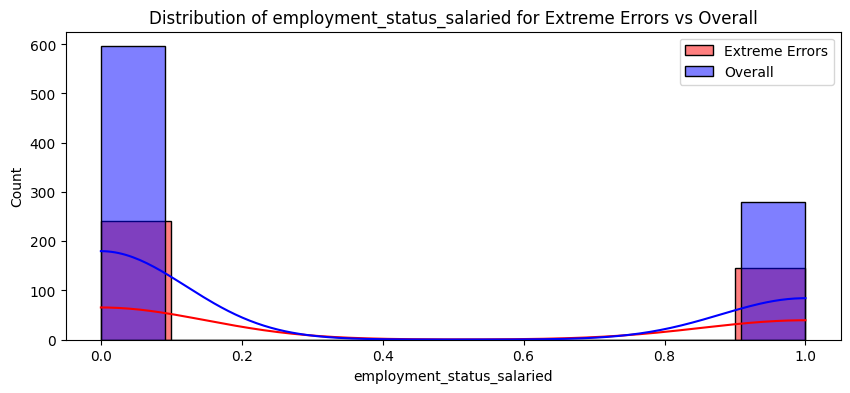

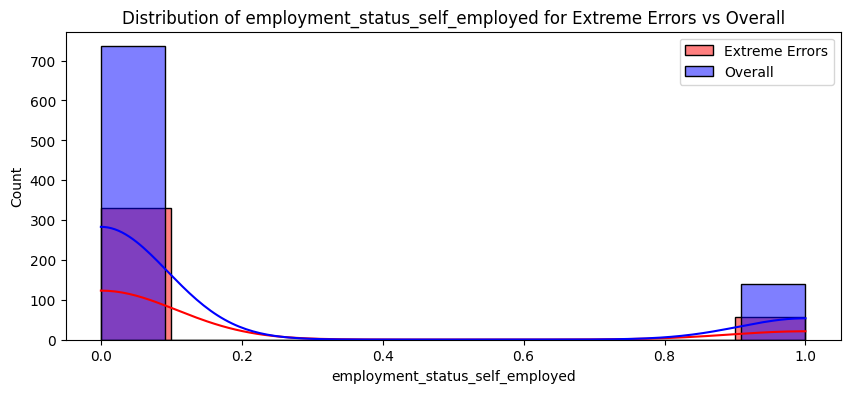

In [144]:
for feature in X_test.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(extreme_errors_df[feature], color='red', label='Extreme Errors', kde=True)
    sns.histplot(X_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()

In [145]:
extreme_errors_df['income_level']=-1

In [146]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed.head()

,age,income_level,income_lakhs,insurance_plan
0,24.0,-2.0,2.0,2.0
1,20.0,-2.0,34.0,1.0
2,24.0,-2.0,1.0,1.0
3,21.0,-2.0,33.0,1.0
4,24.0,-2.0,17.0,1.0


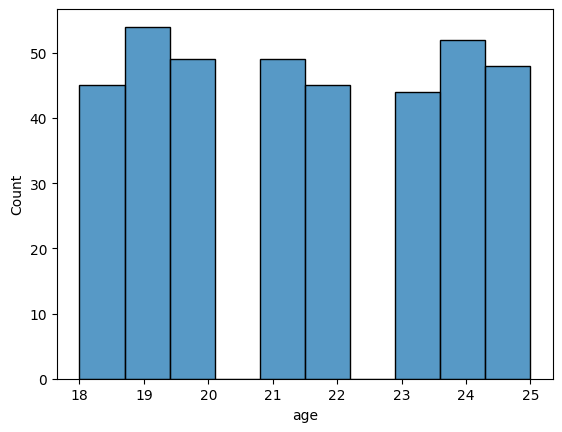

In [147]:
sns.histplot(df_reversed.age)
plt.show()

In [148]:
from joblib import dump

dump(best_model,"../app/artifacts/model_young.joblib")

scaler_with_cols={
    "scaler":scaler,
    "cols_to_scale":cols_to_scale
}

dump(scaler_with_cols,"../app/artifacts/scaler_young.joblib")

['../app/artifacts/scaler_young.joblib']